In [5]:
!pip install prophet

  Using cached prophet-1.1.5-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.5 kB)
  Using cached cmdstanpy-1.2.3-py3-none-any.whl.metadata (4.1 kB)
  Using cached holidays-0.50-py3-none-any.whl.metadata (23 kB)
  Using cached stanio-0.5.0-py3-none-any.whl.metadata (1.3 kB)
Using cached prophet-1.1.5-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (14.4 MB)
Using cached cmdstanpy-1.2.3-py3-none-any.whl (94 kB)
Using cached holidays-0.50-py3-none-any.whl (1.0 MB)
Using cached stanio-0.5.0-py3-none-any.whl (8.0 kB)


In [16]:
import boto3
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly

%matplotlib inline

In [2]:
bucket_name = 'tfl-cycle-data'
s3_file_path = 'Docking_station_data/Waterloo-Jan2016-Apr2024.pkl'
notebook_file_path = 'temp/Waterloo-Jan2016-Apr2024.pkl'
s3 = boto3.client('s3')

s3.download_file(bucket_name, s3_file_path, notebook_file_path)

In [3]:
with open(notebook_file_path, 'rb') as f:
    waterloo_df = pickle.load(f)

In [4]:
waterloo_df.head()

,Rental ID,Start Date,Start Station Name,End Date,End Station Name
0,50755276,2016-10-01 08:41:00,"William IV Street, Strand",2016-10-01 08:47:00,"Waterloo Station 3, Waterloo"
1,50755420,2016-10-01 09:05:00,"Bermondsey Street, Bermondsey",2016-10-01 09:15:00,"Waterloo Station 3, Waterloo"
2,50755598,2016-10-01 09:28:00,"Lollard Street, Vauxhall",2016-10-01 09:36:00,"Waterloo Station 3, Waterloo"
3,50755603,2016-10-01 09:28:00,"Lollard Street, Vauxhall",2016-10-01 09:36:00,"Waterloo Station 3, Waterloo"
4,50756101,2016-10-01 10:12:00,"Waterloo Station 3, Waterloo",2016-10-01 10:27:00,"Braham Street, Aldgate"


In [5]:
waterloo_df_out = waterloo_df[waterloo_df['Start Station Name'] == 'Waterloo Station 3, Waterloo']
waterloo_df_out.set_index('Start Date', inplace=True)
rentals_5min = waterloo_df_out.resample('5min').size().reset_index(name='Rentals')

In [6]:
rentals_5min_reformat = rentals_5min[['Start Date', 'Rentals']].rename(columns={'Start Date': 'ds', 'Rentals': 'y'})
rentals_5min_reformat.head()

,ds,y
0,2015-01-02 01:45:00,1
1,2015-01-02 01:50:00,0
2,2015-01-02 01:55:00,0
3,2015-01-02 02:00:00,0
4,2015-01-02 02:05:00,0


In [7]:
rentals_hourly = rentals_5min_reformat.resample('H', on='ds').sum().reset_index() # need to do this for it to run on current instance size
rentals_hourly.head()

/tmp/ipykernel_25946/2871546009.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rentals_hourly = rentals_5min_reformat.resample('H', on='ds').sum().reset_index() # need to do this for it to run on current instance size


,ds,y
0,2015-01-02 01:00:00,1
1,2015-01-02 02:00:00,0
2,2015-01-02 03:00:00,0
3,2015-01-02 04:00:00,0
4,2015-01-02 05:00:00,0


In [8]:
# Model for outflow
outflow_model = Prophet()


In [9]:
outflow_model.fit(rentals_hourly)

07:49:56 - cmdstanpy - INFO - Chain [1] start processing
07:50:25 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
future_outflow = outflow_model.make_future_dataframe(periods=24, freq='h')

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [11]:
outflow_forecast = outflow_model.predict(future_outflow)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


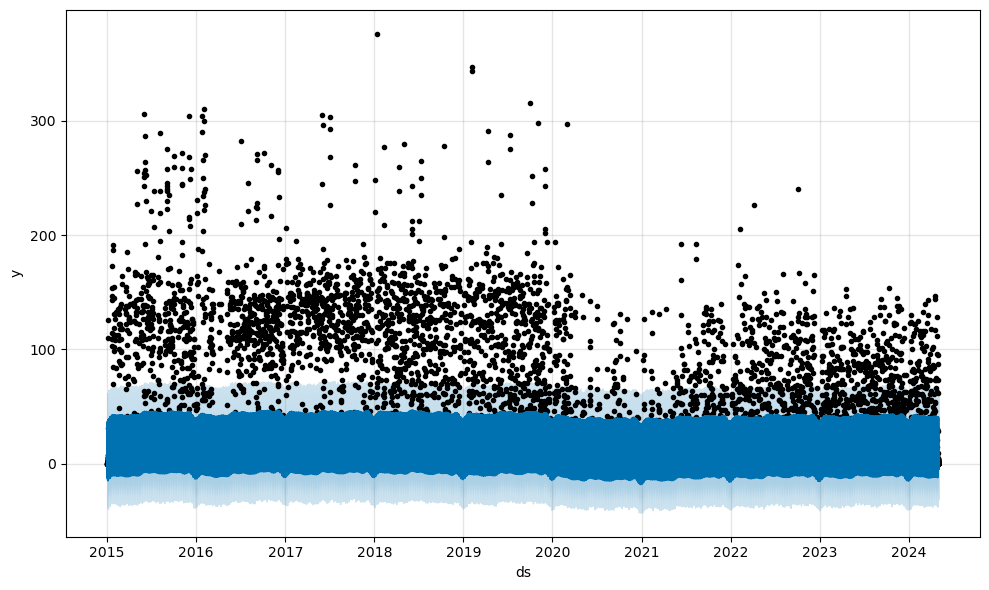

In [12]:
# Plot outflow forecast
fig_outflow = outflow_model.plot(outflow_forecast)
fig_outflow.show()

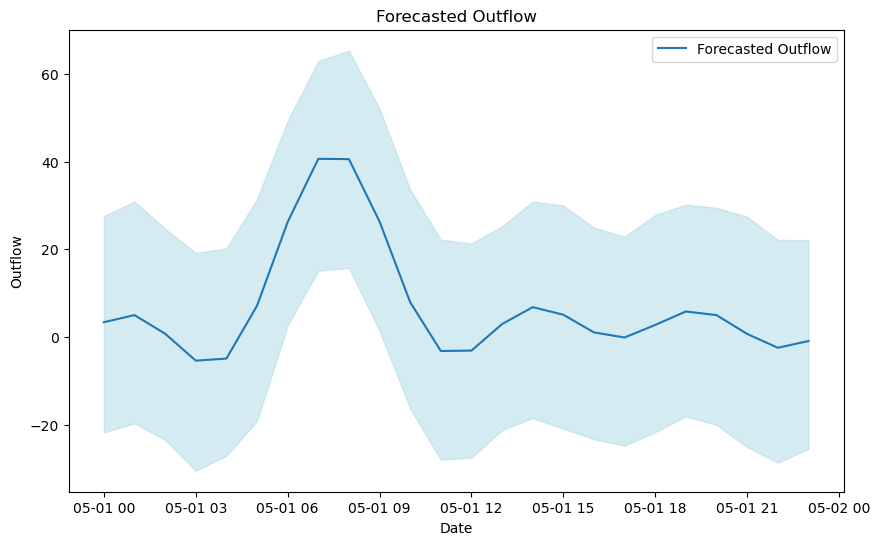

In [17]:
# Filter the forecast to include only the future dates
future_forecast = outflow_forecast[outflow_forecast['ds'] > rentals_hourly['ds'].max()]

# Plot the forecasted data
plt.figure(figsize=(10, 6))
plt.plot(future_forecast['ds'], future_forecast['yhat'], label='Forecasted Outflow')
plt.fill_between(future_forecast['ds'], future_forecast['yhat_lower'], future_forecast['yhat_upper'], color='lightblue', alpha=0.5)
plt.title('Forecasted Outflow')
plt.xlabel('Date')
plt.ylabel('Outflow')
plt.legend()
plt.show()